In [5]:
!pip install scikit-learn

In [4]:
!pip install shap

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [6]:
!pip install plotly

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

import shap

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix,recall_score,roc_curve,roc_auc_score

In [7]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/InstaFakeDetection/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/InstaFakeDetection/test.csv')

In [12]:
train_df = pd.DataFrame(train)
print(train_df.head())

   profile pic  nums/length username  fullname words  nums/length fullname  \
0            1                  0.27               0                   0.0   
1            1                  0.00               2                   0.0   
2            1                  0.10               2                   0.0   
3            1                  0.00               1                   0.0   
4            1                  0.00               2                   0.0   

   name==username  description length  external URL  private  #posts  \
0               0                  53             0        0      32   
1               0                  44             0        0     286   
2               0                   0             0        1      13   
3               0                  82             0        0     679   
4               0                   0             0        1       6   

   #followers  #follows  fake  
0        1000       955     0  
1        2740       533     0  
2 

In [13]:
print(f"Missing values of Training Data\n{train.isnull().sum()}")
print(f"\nDuplicated values in Training Data\n{train.duplicated().sum()}")
print(f"\nMissing values of Test Data\n{test.isnull().sum()}")
print(f"\nDuplicated values in Test Data\n{test.duplicated().sum()}")


Missing values of Training Data
profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
dtype: int64

Duplicated values in Training Data
2

Missing values of Test Data
profile pic             0
nums/length username    0
fullname words          0
nums/length fullname    0
name==username          0
description length      0
external URL            0
private                 0
#posts                  0
#followers              0
#follows                0
fake                    0
dtype: int64

Duplicated values in Test Data
2


In [14]:
train_duplicated=train[train.duplicated(keep=False)]
print(train_duplicated)
test_duplicated=test[test.duplicated(keep=False)]
print(test_duplicated)

     profile pic  nums/length username  fullname words  nums/length fullname  \
196            1                  0.00               2                   0.0   
197            1                  0.00               2                   0.0   
491            1                  0.91               1                   0.0   
525            1                  0.91               1                   0.0   

     name==username  description length  external URL  private  #posts  \
196               0                  48             0        0     222   
197               0                  48             0        0     222   
491               0                   0             0        0       0   
525               0                   0             0        0       0   

     #followers  #follows  fake  
196        5282       652     0  
197        5282       652     0  
491          75        26     1  
525          75        26     1  
    profile pic  nums/length username  fullname words  num

In [15]:
# Removing duplicates
train.drop_duplicates(inplace = True)
test.drop_duplicates(inplace = True)

# Printing new rows count
print('\n')
print(f'Train new rows count: {train.shape[0]}')
print(f'Test new rows count: {test.shape[0]}')



Train new rows count: 574
Test new rows count: 118


In [16]:
def categorize_features(df):
    continuous_features = []
    binary_features = []
    for col in df.columns:
        if df[col].nunique() <= 2:
            binary_features.append(col)
        else:
            continuous_features.append(col)
    return continuous_features, binary_features

In [17]:
continuous_features, binary_features = categorize_features(train)
print('\n')
print('Continuous features:')
print(continuous_features)
print('\n')
print('Binary features:')
print(binary_features)
binary_features.remove('fake')



Continuous features:
['nums/length username', 'fullname words', 'nums/length fullname', 'description length', '#posts', '#followers', '#follows']


Binary features:
['profile pic', 'name==username', 'external URL', 'private', 'fake']


In [18]:
legend_df = train.copy()
legend_df['fake'] = legend_df['fake'].replace({0: 'Real Accounts', 1: "Fake Accounts"})

def create_barplots(df, legend_df):
    for feature in binary_features:
        fig = px.histogram(train, x=feature, color=legend_df['fake'],
                           color_discrete_sequence=['#636EFA','#EF553B'],
                           barmode='group', template='plotly_white',labels={'color': 'Real/Fake'})

        fig.update_layout(title=f'{feature}?',
                          xaxis_title=feature, yaxis_title='Count', xaxis=dict(tickmode='array',tickvals=[0, 1],ticktext=['No', 'Yes']),height = 650)

        fig.show()

In [19]:
create_barplots(train, legend_df)

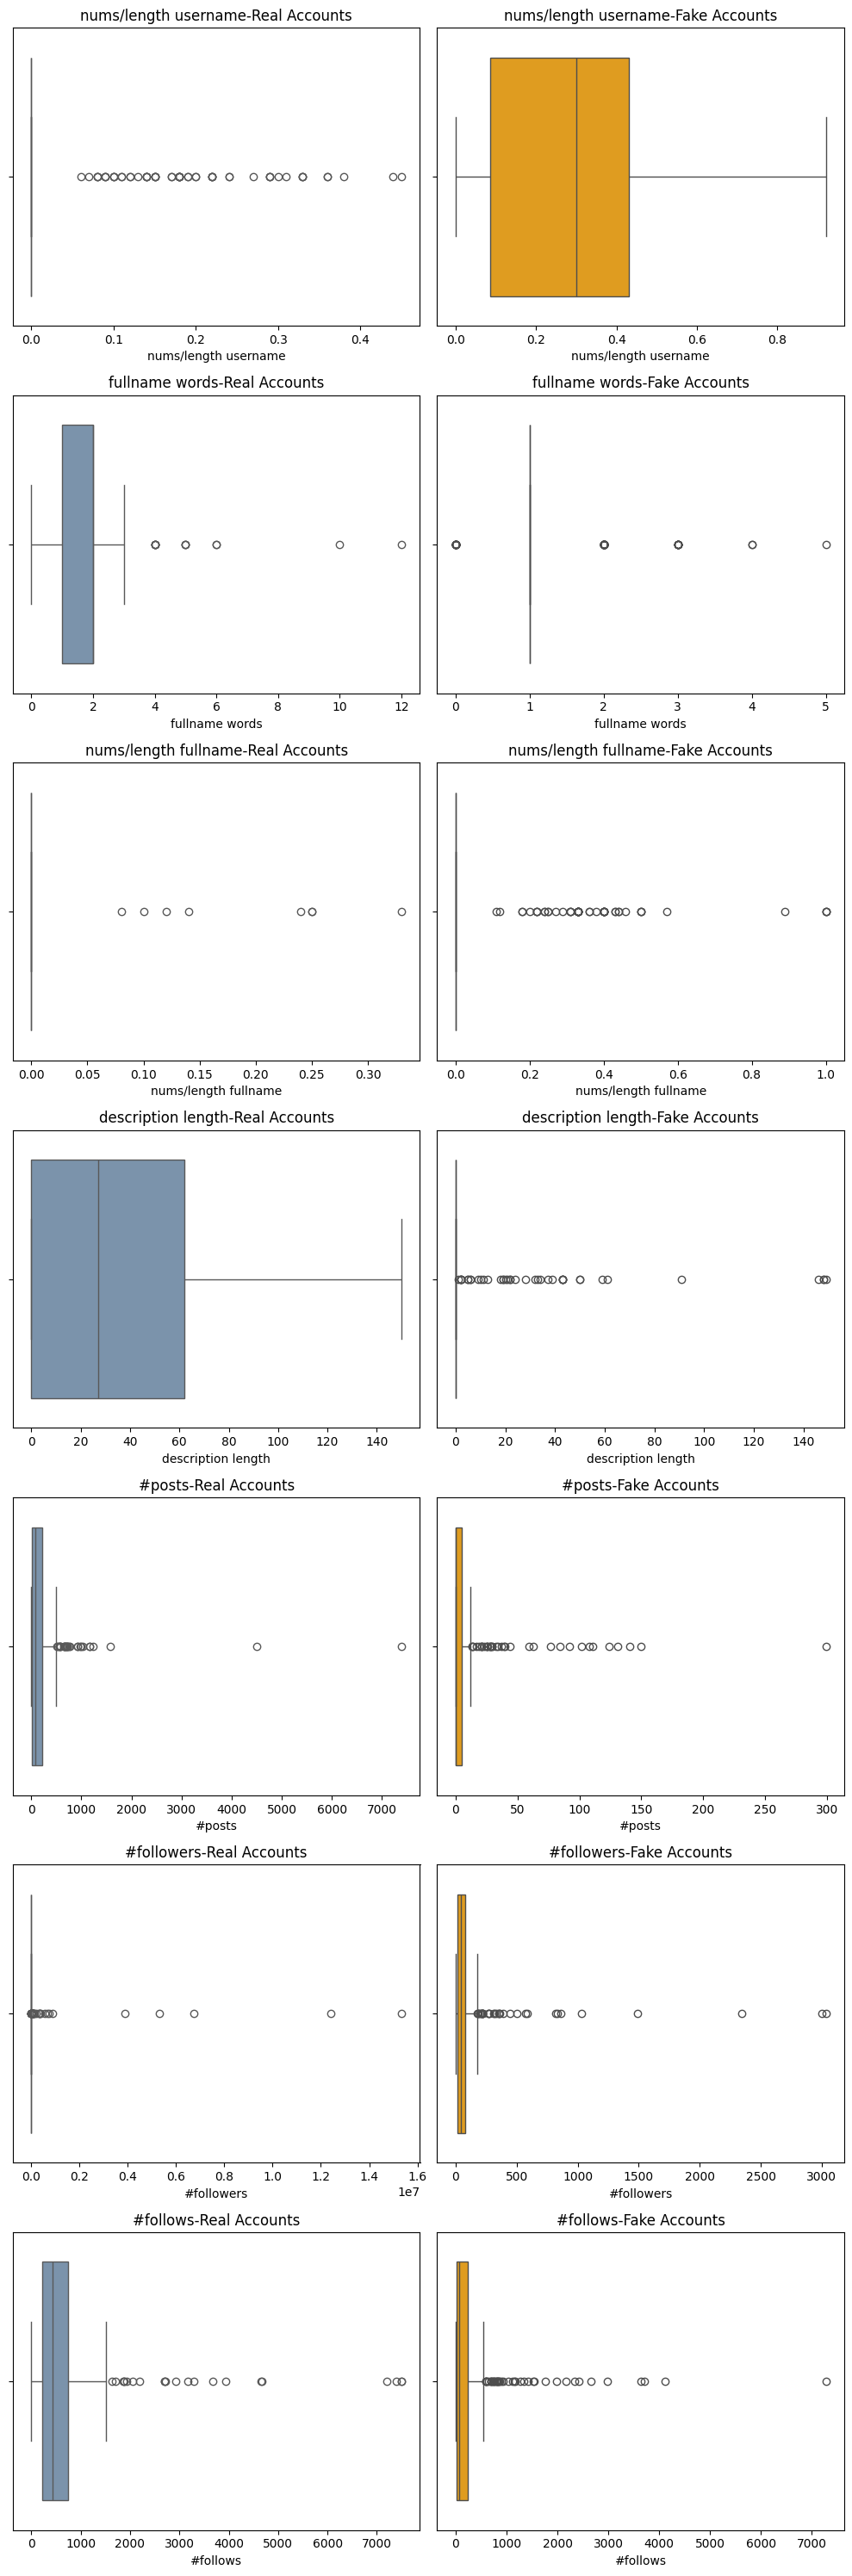

In [ ]:
fig,axes=plt.subplots(nrows=len(continuous_features),ncols=2,figsize=(10,30))
for i , col in enumerate(continuous_features):
  sns.boxplot(data=train[train['fake']==0],x=col,ax=axes[i,0],color='#7393B3')
  sns.boxplot(data=train[train['fake']==1],x=col,ax=axes[i,1],color='orange')
  axes[i,0].set_title(col+"-Real Accounts")
  axes[i,1].set_title(col+"-Fake Accounts")
plt.tight_layout()
plt.show()

In [24]:
fig=px.pie(legend_df,names='fake',title='Trget Variable distribution',color_discrete_sequence=['red','blue'])
fig.update_layout(template='ggplot2')
fig.show()



AUC-ROC Baseline:  0.92




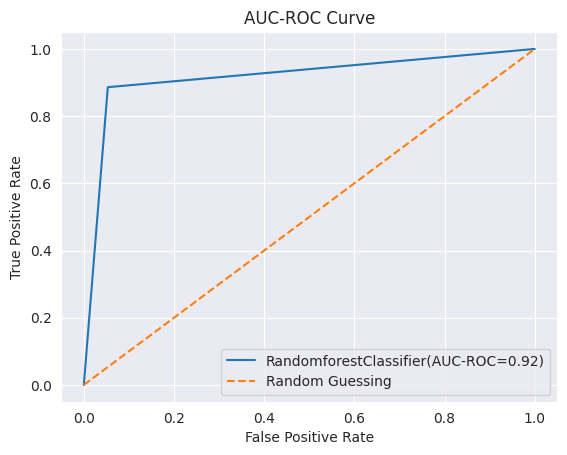



y_val value counts
fake
0    94
1    79
Name: count, dtype: int64


predicted value counts
(array([0, 1]), array([98, 75]))


In [25]:
x=train.drop('fake',axis=1)
y=train['fake']
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.3,random_state=42)
rf=RandomForestClassifier(random_state=42)
rf.fit(x_train,y_train)

y_pred=rf.predict(x_val)
fpr,tpr,thresholds=roc_curve(y_val,y_pred)
roc_df=pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

baseline_score=roc_auc_score(y_val,y_pred)
print('\n')
print('AUC-ROC Baseline: ', baseline_score.round(2))
print('\n')


sns.set_style('darkgrid')
sns.lineplot(x='FPR',y='TPR',data=roc_df,label=f"RandomforestClassifier(AUC-ROC={baseline_score.round(2)})")
plt.plot([0,1],[0,1],linestyle='--',label='Random Guessing')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('\n')
print('y_val value counts')
print(y_val.value_counts())
print('\n')
print('predicted value counts')
print(np.unique(y_pred, return_counts=True))

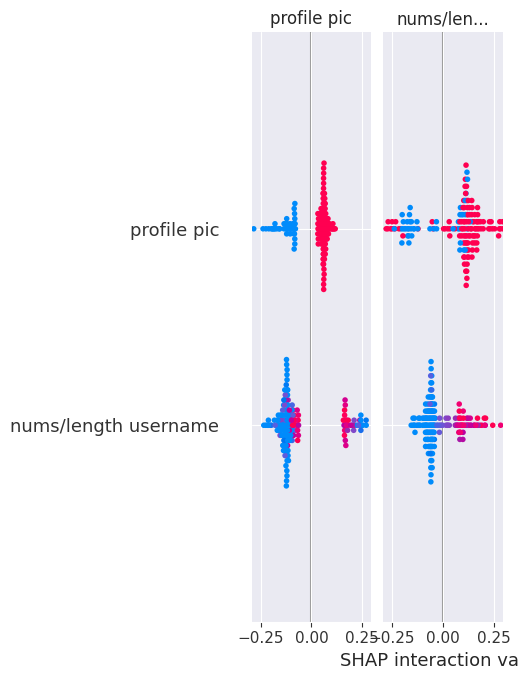

In [26]:
shap_values = shap.TreeExplainer(rf).shap_values(x_val)
shap.summary_plot(shap_values, x_val, plot_type="bar")


In [27]:
train['activity ratio']=np.round(train['#posts']/train['#followers'],2)
train['#followers > #follows?']=(train['#followers']>train['#follows'].astype(int))


In [29]:
train.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,activity ratio,#followers > #follows?
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0,0.03,True
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0,0.10,True
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0,0.08,True
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0,1.64,False
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0,0.04,True


In [30]:
fig = px.histogram(train, x=train['#followers > #follows?'], color=legend_df['fake'],
                   color_discrete_sequence=['#636EFA','#EF553B'],
                   barmode='group', template='plotly_white',labels={'color': 'Real/Fake'})

fig.update_layout(title='More Followers than Follows Distribution',
                  xaxis_title='#followers > #follows?', yaxis_title='Count', xaxis=dict(tickmode='array',
                  tickvals=[0, 1],
                  ticktext=['No', 'Yes']),
                  height = 800)

fig.show()

In [ ]:
fig=px.box(train,x='fake',y='activity ratio',color=legend_df['fake'],title="Activity Ratio")
fig.update_layout(xaxis_title="Real/Fake", yaxis_title='Count', xaxis=dict(tickmode='array',
                                                                               tickvals=[0, 1],
ticktext=['Real Accounts', 'Fake Accounts']
),
height = 650)
fig.show()

In [ ]:
train.isnull().sum()

profile pic                0
nums/length username       0
fullname words             0
nums/length fullname       0
name==username             0
description length         0
external URL               0
private                    0
#posts                     0
#followers                 0
#follows                   0
fake                       0
activity ratio            15
#followers > #follows?     0
dtype: int64

In [ ]:
train.isin([np.inf,-np.inf]).sum()

In [ ]:
train.replace([np.inf,-np.inf],np.nan,inplace=True)
train.dropna(inplace=True)

In [ ]:
df_means=train.mean().round(2)
df_stds=train.std().round(2)
results=pd.concat([df_means,df_stds],axis=1)
results.columns=['Mean','Standard Deviaton']
results

,Mean,Standard Deviaton
profile pic,0.72,0.45
nums/length username,0.16,0.21
fullname words,1.47,1.06
nums/length fullname,0.04,0.13
name==username,0.03,0.18
description length,23.27,38.13
external URL,0.12,0.33
private,0.37,0.48
#posts,110.94,408.69
#followers,88366.21,926256.64


In [ ]:
X=train.drop('fake',axis=1)
y=train.fake
x_train, x_val, y_train, y_val = train_test_split(X, y,test_size = 0.35, random_state = 123)


In [ ]:
models={
    "XGBoost":XGBClassifier(random_state=42),
    "LGBM":LGBMClassifier(random_state=42),
    "CatBoost":CatBoostClassifier(verbose=False,random_state=42),
    "AdaBoost":AdaBoostClassifier(random_state=42)
}
pipelines={}
for name,model in models.items():
  pipelines[name]=Pipeline([
      ("scaler",StandardScaler()),
      ("Model",model)
  ])

results={}
for name,pipeline in pipelines.items():
  pipeline.fit(x_train,y_train)
  y_pred=pipeline.predict(x_val)
  auc=roc_auc_score(y_val,y_pred)
  results[name]={
      "pipeline":pipeline,
      "auc":auc
  }
  print(f"{name}:AUC-ROC score = {auc:.2f}")
plt.figure(figsize=(8,6))
for name,result in results.items():
  fpr,tpr,threshold=roc_curve(y_val,result["pipeline"].predict(X_val))
  plt.plot(fpr,tpr,label=f"{name} (AUC = {result['auc']:.2f})")
plt.plot([0,1],[0,1],'k--',label='Radom Guessing')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
test['activity ratio']=np.round(test['#posts']/test['#follows'],2)
test['#followers > #follows?']=(test['#followers']>test['#follows']).astype(int)

test.replace([np.inf,-np.inf],np.nan,inplace=True)
test.dropna(inplace=True)
test

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,activity ratio,#followers > #follows?
2,1,0.00,2,0.0,0,82,0,1,319,328,668,0,0.48,0
3,1,0.00,1,0.0,0,143,0,1,273,14890,7369,0,0.04,1
4,1,0.50,1,0.0,0,76,0,1,6,225,356,0,0.02,0
5,1,0.00,1,0.0,0,0,0,1,6,362,424,0,0.01,0
6,1,0.00,1,0.0,0,132,0,1,9,213,254,0,0.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.0,0,0,0,0,13,114,811,1,0.02,0
116,1,0.40,1,0.0,0,0,0,0,4,150,164,1,0.02,0
117,1,0.00,2,0.0,0,0,0,0,3,833,3572,1,0.00,0
118,0,0.17,1,0.0,0,0,0,0,1,219,1695,1,0.00,0


In [ ]:
x=test.drop('fake',axis=1)
y=test.fake


In [ ]:
y.value_counts()

fake
0    58
1    58
Name: count, dtype: int64

In [ ]:
x

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,activity ratio,#followers > #follows?
2,1,0.00,2,0.0,0,82,0,1,319,328,668,0.48,0
3,1,0.00,1,0.0,0,143,0,1,273,14890,7369,0.04,1
4,1,0.50,1,0.0,0,76,0,1,6,225,356,0.02,0
5,1,0.00,1,0.0,0,0,0,1,6,362,424,0.01,0
6,1,0.00,1,0.0,0,132,0,1,9,213,254,0.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.0,0,0,0,0,13,114,811,0.02,0
116,1,0.40,1,0.0,0,0,0,0,4,150,164,0.02,0
117,1,0.00,2,0.0,0,0,0,0,3,833,3572,0.00,0
118,0,0.17,1,0.0,0,0,0,0,1,219,1695,0.00,0


In [ ]:
catboost_pipeline = results["CatBoost"]["pipeline"] # Creating a CatBoost model
y_pred = catboost_pipeline.predict(x)

CatBoos: AUC-ROC score on unseen data = 0.9138


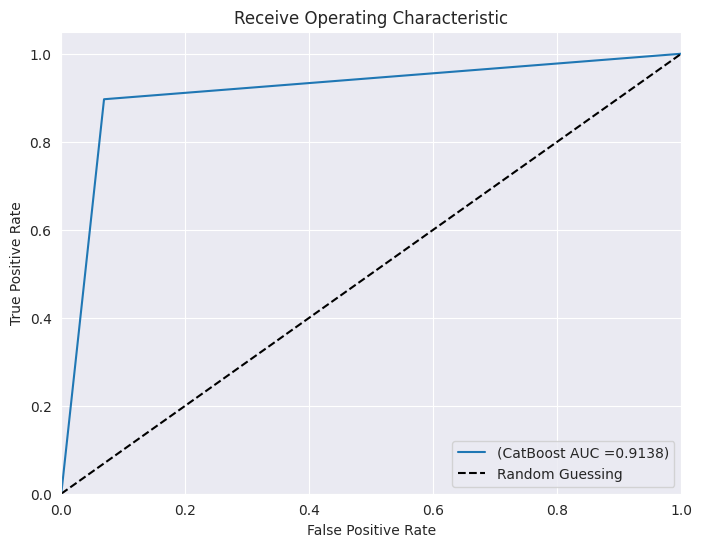

Value counts for y:
fake
0    58
1    58
Name: count, dtype: int64


Value counts for y_pred:
0    60
1    56
Name: count, dtype: int64




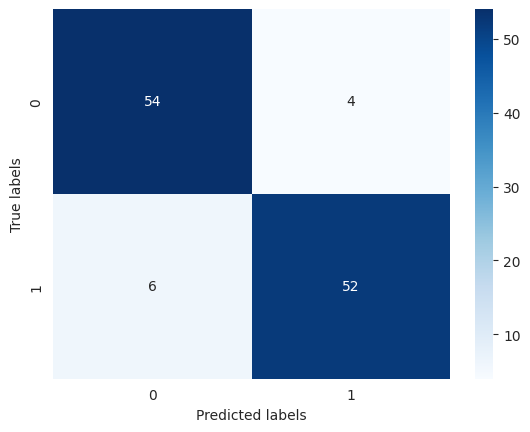



Recall Score: 90.0%


In [ ]:
auc=roc_auc_score(y,y_pred)
print(f"CatBoos: AUC-ROC score on unseen data = {auc:.4f}")

plt.figure(figsize=(8,6))
fpr,tpr,threshold=roc_curve(y,catboost_pipeline.predict(x))
plt.plot(fpr,tpr,label=f"(CatBoost AUC ={auc:.4f})")
plt.plot([0,1],[0,1],'k--',label='Random Guessing')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receive Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

print("Value counts for y:")
print(y.value_counts())
print('\n')
print("Value counts for y_pred:")
print(pd.Series(y_pred).value_counts())
print('\n')

cm=confusion_matrix(y,y_pred)
sns.heatmap(cm,annot=True,cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()
print('\n')
print(f'Recall Score: {np.round(recall_score(y, y_pred),2) * 100}%')